## Step 1: Check each website for redirects

In [67]:
import pandas as pd
from tldextract import extract as tld
import numpy as np
from tqdm import tqdm
import requests
from requests.exceptions import SSLError, Timeout, RequestException
import warnings
import urllib
from urllib.parse import urlparse
import re
from urllib3.exceptions import InsecureRequestWarning
warnings.simplefilter('ignore', InsecureRequestWarning)
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.transforms import Bbox


In [22]:
def isgov(x):
    if (x == None) or (type(x) != str):
        return np.nan
    elif x.startswith('http'):
        return tld(x).suffix=='gov'
    else:
        return x.endswith('.gov')


def get_netloc(x, remove_www=True):
    # return the netloc of a url (e.g., www.example.com)
    if type(x)==str:
        netloc = urllib.parse.urlparse(x).netloc
        if remove_www and netloc.startswith('www.'):
            netloc = netloc[4:]
    else:
        netloc = ''
    return netloc

In [79]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

# function to get the final url after redirects
def get_final_url(initial_url, max_retries=2, timeout=10):
    def try_url(url):
        for _ in range(max_retries):
            try:
                response = requests.get(url, allow_redirects=True, timeout=timeout, headers=headers, verify=False)
                return response.url
            except (SSLError, Timeout, RequestException):
                continue
        return None

    # Parse the initial URL
    parsed = urlparse(initial_url)
    scheme = parsed.scheme if parsed.scheme else 'http'
    domain = parsed.netloc if parsed.netloc else parsed.path.split('/')[0]
    path = parsed.path if parsed.netloc else '/'.join(parsed.path.split('/')[1:])
    
    # Ensure the path starts with a '/'
    if path and not path.startswith('/'):
        path = '/' + path

    # Define the endpoints to check, starting with the initial URL
    endpoints = [
        initial_url,
        f"{scheme}://{domain}{path}",
        f"{scheme}://www.{domain}{path}",
    ]

    # Add the other scheme if not already included
    other_scheme = 'https' if scheme == 'http' else 'http'
    if f"{other_scheme}://" not in [ep.lower() for ep in endpoints]:
        endpoints.extend([
            f"{other_scheme}://{domain}{path}",
            f"{other_scheme}://www.{domain}{path}"
        ])

    # Remove any duplicates while preserving order
    endpoints = list(dict.fromkeys(endpoints))

    for endpoint in endpoints:
        result = try_url(endpoint)
        if result:
            return result

    return "All endpoints failed"

In [ ]:
df = pd.read_csv('data/LEO_combined.csv') # read CTCL dataset

In [450]:
# find the redirected URL for each row
wr = 'website_redirect'

for i in tqdm(df.index):
    try:
        final_url = get_final_url(df.loc[i, 'website'])
        df.at[i, wr] = final_url
    except Exception as e:
        df.at[i, wr] = f"Error: {type(e).__name__}"

100%|██████████| 12654/12654 [2:36:19<00:00,  1.35it/s]  


In [ ]:
'''
same website: indicates that the ultimate destination of the CTCL URL is identical to the CTCL website
same netloc: indicates that the ultimate destination of the CTCL URL has the same network location (i.e., the example.com” part of the URL) as the CTCL URL but a different overall URL (e.g., perhaps a provided website example.com/some_page redirects to example.com/some_other_page)
different netloc: indicates that the CTCL website redirects to a URL with a different network location
error: indicates that my script could not connect to the CTCL URL at all. This may mean that the website is down. However, it is possible that the website is perfectly accessible via browser but not via my script, due to web scraping being a slightly different
no website: indicates that no website was provided by CTCL, so there was nothing to check

'''

def normalize_url(url):
        # If the URL doesn't start with a scheme, add 'http://' as a default
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url
        
        # Parse the URL
        parsed = urlparse(url)
        
        # Remove 'www.' from the beginning of the netloc if it exists
        netloc = parsed.netloc
        if netloc.startswith('www.'):
            netloc = netloc[4:]
        
        # Reconstruct the URL without scheme, 'www.', and trailing slash
        normalized = netloc + parsed.path.rstrip('/')
        
        # Add query parameters if they exist
        if parsed.query:
            normalized += '?' + parsed.query
        
        # Add fragment if it exists
        if parsed.fragment:
            normalized += '#' + parsed.fragment
        
        return normalized.lower()  # Convert to lowercase for case-insensitive comparison

def determine_website_status(row):
    if pd.isna(row['website']):
        return 'no website', np.nan
    elif row[wr] == 'All endpoints failed':
        return 'error', np.nan
    elif row['website'] == row[wr] or (normalize_url(row['website']) == normalize_url(row[wr])):
        return 'same website', row[wr]
    elif get_netloc(row['website']) != get_netloc(row[wr]):
        return 'different netloc', row[wr]
    elif get_netloc(row['website']) == get_netloc(row[wr]):
        return 'same netloc', row[wr]
    else:
        return 'needs status', row[wr]

ws = 'website_status'
df[[ws, wr]] = df.apply(determine_website_status, axis=1, result_type='expand')


In [92]:
cols = ['State', 'County', 'Jurisdiction', 'Office UUID',
       'Office Name_previous', 'Office Name', 'Tier Level', 'OCDID', 'FBID',
       'website', 'phone_number', 'is_hybrid_personal', 'is_primary_leo',
       'is_elected', 'website_redirect', 'website_status']

In [95]:
df[cols].to_csv('data/LEO_combined_with_redirects.csv', index=False)

## Analysis

In [71]:
df = pd.read_csv('data/LEO_combined_with_redirects.csv')
pshtt = pd.read_pickle('data/pshtt_processed_2024.pickle.zip') # processed separately with pshtt

df = pd.merge(df, pshtt[['Office UUID', 'Domain Supports HTTPS']], on='Office UUID', how='left')

# merge in county-equivalents
# Read the file into a DataFrame
counties = pd.read_csv('data/county_adjacency2023.txt', sep='|')

# Drop all columns except the first one
counties = counties[['County Name']]

counties['county-equivalent level'] = True

# Split 'County Name' into 'County' and 'State'
counties[['County', 'State']] = counties['County Name'].str.rsplit(', ', n=1, expand=True)
counties = counties[counties['State'] != 'PR']

# Drop the original 'County Name' column
counties.drop(columns=['County Name'], inplace=True)

# Reduce to just the unique counties
counties = counties.drop_duplicates().reset_index(drop=True)

df = df.merge(counties, left_on=[df['Jurisdiction'].str.lower(), 'State'], right_on=[counties['County'].str.lower(), 'State'], how='outer', suffixes=('', '_county'), indicator=True)
df = df.drop(columns=['key_0', 'County_county'])


In [72]:
wr = 'website_redirect'
def remove_port_number(url):
    # Use regex to remove the port number
    return re.sub(r':\d+$', '', url)

df['netloc'] = df[wr].apply(lambda x: get_netloc(x, remove_www=False)).apply(remove_port_number)
df['isgov'] = df['netloc'].apply(isgov)

def preprocess(df):
    # drop rows with no website
    df = df.dropna(subset='website')

    # deduplicate URLs, preferring to keep the rows of the highest-level LEOs
    # (primarily, those that are both primary LEOs and secondarily, those that are county-level)
    df = df.sort_values(['is_primary_leo', 'county-equivalent level'])
    df = df.drop_duplicates(subset='netloc', keep='last')

    return df

df = preprocess(df)

In [26]:
# write a convenience function to print the results we are interested in,
# for any given slice of the data and any set of queries

def print_results(x, columns=['isgov']):
    for col in columns:
        print(f'{col}')
        vc = x[col].value_counts()
        if True not in list(vc.keys()):
            t = 0
        else:
            t = vc[True]
        if False not in list(vc.keys()):
            f = 0
        else:
            f = vc[False]
        proportion = str(round((t / (t+f))*100,1)) + '%'
        print(f"{t} / {t+f} ({proportion})")

    
primary = (df['is_primary_leo']) & (df['website'].isna()==False) # find primary LEOs with a website
print_results(df[primary]) # primary LEOs

isgov
2138 / 6990 (30.6%)


In [27]:
print_results(df[df['county-equivalent level']==True]) # county-equivalents

isgov
1131 / 2922 (38.7%)


In [7]:
top = [('Los Angeles', 'CA'),
 ('Cook', 'IL'),
 ('Harris', 'TX'),
 ('Maricopa', 'AZ'),
 ('San Diego', 'CA'),
 ('Orange', 'CA'),
 ('Miami-Dade', 'FL'),
 ('Kings', 'NY'),
 ('Dallas', 'TX'),
 ('Riverside', 'CA'),
 ('Queens', 'NY'),
 ('Clark', 'NV'),
 ('King', 'WA'),
 ('San Bernardino', 'CA'),
 ('Tarrant', 'TX'),
 ('Bexar', 'TX'),
 ('Broward', 'FL'),
 ('Santa Clara', 'CA'),
 ('Wayne', 'MI'),
 ('Alameda', 'CA')
]

def get_top_counties(df):
    dftop = pd.DataFrame()

    # add all offices with ___ County in the name
    for t in top:
        dftop = pd.concat([dftop, df[(df['State']==t[1]) & (df['Office Name'].str.contains('County')) & (df['County']==t[0])]])

    # add NYC since it doesn't include "County"
    dftop = pd.concat([dftop, df[(df['State']=='NY') & (df['County'].str.contains('Bronx')) & (df['is_primary_leo']==True)]])

    return dftop

print_results(get_top_counties(df).sort_values('State').drop_duplicates('netloc'))

isgov
10 / 19 (52.6%)


In [8]:
gov = 'gov'
ssl = 'ssl'

data = {
    'primary': [1747/7010, 2138/6990, 6260/7010, 6573/6990], #gov22, gov24, ssl22, ssl24
    'counties': [866/2764, 1131/2922, 2463/2764, 2740/2921],  #gov22, gov24, ssl22, ssl24
    'biggest': [8/19, 10/19, 17/19, 19/19]                   #gov22, gov24, ssl22, ssl24
}

groupings = data.keys()

# Define the index for the DataFrame
index = pd.MultiIndex.from_tuples([
    (gov, 2022),
    (gov, 2024),
    (ssl, 2022),
    (ssl, 2024)
], names=['protection', 'year'])

# Create the DataFrame
results = pd.DataFrame(data, index=index)

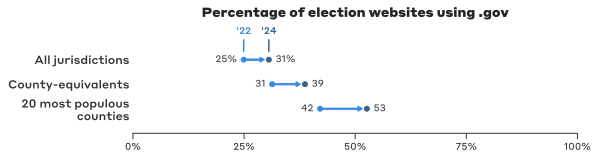

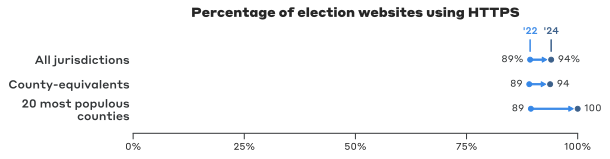

In [65]:
sns.set_style('ticks')

%config InlineBackend.figure_format = 'svg'
# plt.rcParams['figure.dpi'] = 200

fe = font_manager.FontEntry(
    fname='/Users/will/Library/Fonts/StyreneA-Black.otf',
    name='StyreneABlack')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname='/Users/will/Library/Fonts/StyreneA-Medium.otf',
    name='StyreneAMedium')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

fe = font_manager.FontEntry(
    fname='/Users/will/Library/Fonts/StyreneA-Regular.otf',
    name='StyreneARegular')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine

matplotlib.rcParams['font.family'] = 'StyreneARegular' # = 'your custom ttf font name'


delta = -0.2
y = [-delta, 0, delta]
# colors = ['blue', 'green', 'red']
# colors = ['#3C608A', '#3C608A', '#3C608A']
blue = '#3C608A'
lightgray = '#d3d8d6'
darkgray = '#333638'
red = '#e43e47'
lightblue = '#3687e7'

color2 = blue
color1 = lightblue


titles = ['Percentage of election websites using .gov',
          'Percentage of election websites using HTTPS']
x_label_offset = 0.015
y_label_offset = 0.23
ms = 5 # markersize

label_fontsize = 9.5

for i, category in enumerate([gov, ssl]):
    fig, ax = plt.subplots(figsize=(8, 2))
    for j, grouping in enumerate(groupings):
        start = results.loc[(category, grouping)][2022]
        end = results.loc[(category, grouping)][2024]

        # OPTION 1 arrows
        ax.arrow(start, y[j], end - start-.01, 0, 
                 head_width=0.04, head_length=0.01, fc=color1, ec=color1,
                 width=.01,
                 overhang=0, length_includes_head=True, zorder=100)
                # Add starting dot
        ax.plot(start, y[j], 'o', color=color1, zorder=100, markersize=ms)


        # OPTION 2 lines
        # # Draw line connecting 2022 and 2024
        # ax.plot([start, end], [y[j], y[j]], color=colors[j], zorder=99)

        # # Add empty dot for 2022
        # ax.plot(start, y[j], 'o', color=blue, markerfacecolor='white', zorder=100, clip_on=False)
        # ax.plot(start, y[j], 'o', color=color1, zorder=100, markersize=ms, clip_on=False)
        
        # # Add filled dot for 2024
        ax.plot(end, y[j], 'o', color=color2, zorder=100, markersize=ms, clip_on=False)

        percent_marker = '%' if j == 0 else ''
        start_label = f'{round(start * 100)}{percent_marker}'
        end_label = f'{round(end * 100)}{percent_marker}'
        ax.text(start - x_label_offset, y[j], start_label, ha='right', va='center', color=darkgray, fontsize=label_fontsize)
        ax.text(end + x_label_offset, y[j], end_label, ha='left', va='center', color=darkgray, fontsize=label_fontsize)


        if j == 0:
            # ax.text(start - h_label_offset, y[j], "'22", ha='right', va='center', color='black')
            # ax.text(end + h_label_offset, y[j], "'24", ha='left', va='center', color='black')
            ax.text(start, y[j]+ y_label_offset, "'22", ha='center', va='center', color=color1, fontsize=label_fontsize, fontname='StyreneAMedium')
            ax.text(end, y[j]+ y_label_offset, "'24", ha='center', va='center', color=color2, fontsize=label_fontsize, fontname='StyreneAMedium')
            
            ax.plot([start, start], [y[j]+y_label_offset*.3, y[j]+y_label_offset*.7], color=color1, zorder=0)
            ax.plot([end, end], [y[j]+y_label_offset*.3, y[j]+y_label_offset*.7], color=color2, zorder=0)


    # # Setting the y-axis labels
    ax.set_yticks(y)
    ax.set_yticklabels(['All jurisdictions', 'County-equivalents', '20 most populous\ncounties'],
                       fontname='StyreneAMedium', color=darkgray, fontsize=11.5)
    ax.set_ylim([delta*2, -delta*2.5])
    ax.grid(False)
 

    # # Setting the x-axis label
    # ax.set_xlabel('Percent of sites on .GOV')
    ax.set_xlim([0, 1])
    # ax.set_xticks(np.linspace(0, 1, 11))
    # ax.set_xticklabels([f'{i}%' for i in range(0, 101, 10)], fontsize=label_fontsize)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=label_fontsize)
    # ax.set_xticks(np.linspace(0, 1, 2))
    # ax.set_xticklabels(["0%", "100%"])
    sns.despine(left=True)

    # Remove y-axis
    # ax.yaxis.set_visible(False)
    ax.tick_params(axis='y', length=0)
    
    
    ax.spines['bottom'].set_color(darkgray)
    ax.spines['bottom'].set_linewidth(1)
    ax.tick_params(axis='x', color=darkgray, width=1)

    # # Remove grid lines
    ax.grid(False)

    # # Remove the background
    ax.set_facecolor('white')
    

    # # Display the plot
    plt.title(titles[i], fontname='StyreneABlack', fontsize=13)
    plt.show()

    # fig.savefig(f'plot_{category}.png', dpi=300, bbox_inches='tight', transparent=False)
    fig.savefig(f'plot_{category}.png', dpi=300, bbox_inches=Bbox([[-.75, -.1], [7.55, 2]]), transparent=False)

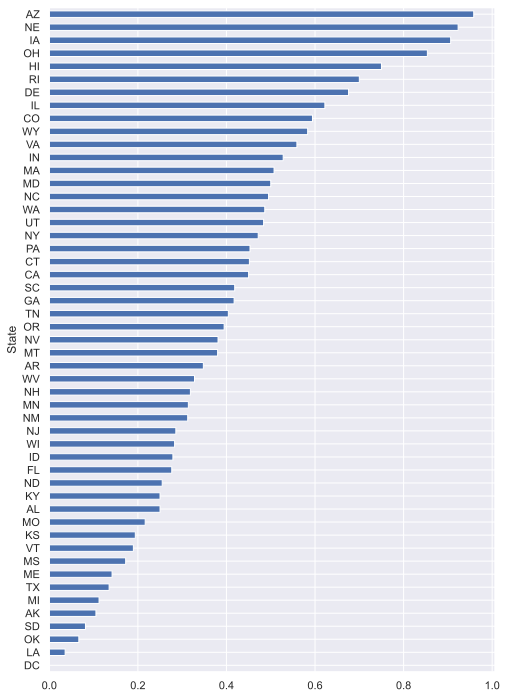

In [79]:
# overall adoption
numerator = df[df['is_primary_leo']].groupby('State')['isgov'].sum().sort_values(ascending=False)
denominator = df[df['is_primary_leo']].groupby('State').apply(len, include_groups=False)

(numerator/denominator).sort_values(ascending=True).plot(kind='barh', figsize=(8, 12));

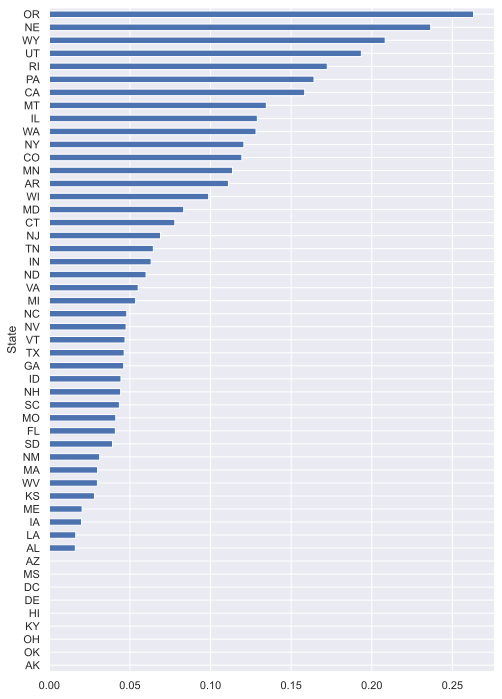

In [81]:
# migration to .gov
df = pd.read_csv('data/22_24_comparison.csv')

df['moved'] = df['any GOV'] & ~df['any GOV_22']

numerator = df[df['is_primary_leo']].groupby('State').moved.sum().sort_values(ascending=False)

# denominator 
denominator = df[df['is_primary_leo']].groupby('State').size().sort_values(ascending=False)

# fraction
(numerator/denominator).sort_values(ascending=False)

# plot
# (numerator/denominator).sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))

# plot horizontal bar
(numerator/denominator).sort_values(ascending=True).plot(kind='barh', figsize=(8, 12));